Exploratory Data Analysis

In [32]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

cashrequest_df = pd.read_csv("project_dataset/cashreq-clean.csv")
fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")
print("✅ done!")

# Fórmula de LTV por usuario = Suma de todas las fees que ha pagado ese usuario
# sum of all fee_amount from fees-with-cohort-and-user-id-clean.csv where user_id matches

# Fórmula de LTV por cohort:  Promedio de LTV de todos los usuarios en ese cohort
# LTV_cohort = average of all LTV_user values within the same cohort

✅ done!


/var/folders/bx/bzgj6qhd5_l2_b7d0v7r7r7r0000gn/T/ipykernel_8807/3950483872.py:7: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")


In [33]:
# cashrequest_df.head()

In [34]:
fees_and_cohorts_df.head()

,Unnamed: 0,fee_id,cash_request_id,type,fee_status,category,total_amount,fee_reason,fee_created_at,fee_updated_at,...,recovery_status,reco_creation,reco_last_update,was_moderated,was_deleted_account,was_sent,was_money_back,invalid_date_sequence,user_first_cash_request_date,cohort
0,0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,...,pending,2020-10-11 22:52:52.274832+00,2020-12-20 22:40:42.556534+00,False,False,True,True,False,2020-09-07 10:46:57.780263+00:00,2020-09
1,1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,...,completed,2020-09-09 20:51:17.992852+00,2020-10-10 22:58:13.306027+00,True,False,True,True,False,2020-06-21 18:38:39.791418+00:00,2020-06
2,2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,...,NaN,NaN,NaN,False,False,True,True,False,2020-10-23 10:10:43.278601+00:00,2020-10
3,3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00,2020-10-31 15:46:53.643982+00,...,NaN,NaN,NaN,False,False,True,True,False,2020-10-31 15:46:14.156730+00:00,2020-10
4,4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00,2020-10-13 14:25:03.267983+00,...,completed,2020-10-24 22:43:13.278707+00,2020-11-02 14:45:20.333109+00,True,True,True,True,False,2020-06-27 18:06:04.818312+00:00,2020-06


## LTV per user / cohort

In [35]:
# Ingreso total generado por los usuarios de cada cohorte / Número de usuarios en la cohorte
# Los gráficos representarán el LTV promedio por usuario de cada cohorte.

In [36]:
# Q1: Sumar ingresos per user / cohort
accepted_fees = fees_and_cohorts_df[fees_and_cohorts_df['fee_status'] == 'accepted']

user_total_per_cohort = accepted_fees.groupby(["cohort", "user_id"])["total_amount"].sum().reset_index()
user_total_per_cohort.head()

,cohort,user_id,total_amount
0,2019-11,47.0,30.0
1,2019-12,52.0,10.0
2,2019-12,53.0,5.0
3,2019-12,77.0,5.0
4,2019-12,92.0,15.0


In [37]:
# Q2: Revenue promedio per user / cohort
avg_revenue_per_user_by_cohort = user_total_per_cohort.groupby("cohort")["total_amount"].mean().reset_index()
avg_revenue_per_user_by_cohort.columns = ["cohort", "avg_revenue_per_user"]
avg_revenue_per_user_by_cohort.head()

,cohort,avg_revenue_per_user
0,2019-11,30.000000
1,2019-12,13.614458
2,2020-01,13.939394
3,2020-02,14.431818
4,2020-03,14.333333


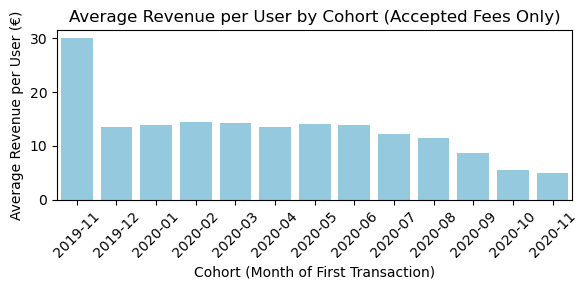

'🧠 Interpretation of Results:\n✅ 2019-11 cohort has the highest average revenue per user, by far — almost $50 per user, which may indicate:\n+ Very engaged early adopters\n+ A small but high-value user base\n+ Or longer time to accumulate revenue\n\n📉 From 2019-12 to mid-2020, average revenue per user remains fairly stable (~$18–$21) — these cohorts might have more consistent behavior.\n\n⬇️ Starting around 2020-08, there’s a clear downward trend:\nCohorts like 2020-09, 2020-10, and 2020-11 show much lower user value, around $5–$10 per user, this could indicate:\n+ Decreased user engagement\n+ Shorter lifetime (users haven\'t been active long enough)\n+ Lower conversion or retention quality\n+ Or you’re acquiring lower-value users as you scale"\n'

In [38]:
# Q2 Plotting
plt.figure(figsize=(6, 3))
sns.barplot(
    data=avg_revenue_per_user_by_cohort,
    x="cohort",
    y="avg_revenue_per_user",
    color="skyblue"
)

# Titles and labels
plt.title("Average Revenue per User by Cohort (Accepted Fees Only)")
plt.xlabel("Cohort (Month of First Transaction)")
plt.ylabel("Average Revenue per User (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

"""🧠 Interpretation of Results:
✅ 2019-11 cohort has the highest average revenue per user, by far — almost $50 per user, which may indicate:
+ Very engaged early adopters
+ A small but high-value user base
+ Or longer time to accumulate revenue

📉 From 2019-12 to mid-2020, average revenue per user remains fairly stable (~$18–$21) — these cohorts might have more consistent behavior.

⬇️ Starting around 2020-08, there’s a clear downward trend:
Cohorts like 2020-09, 2020-10, and 2020-11 show much lower user value, around $5–$10 per user, this could indicate:
+ Decreased user engagement
+ Shorter lifetime (users haven't been active long enough)
+ Lower conversion or retention quality
+ Or you’re acquiring lower-value users as you scale"
"""


In [39]:
# Q3: Ver en cuántas cohorts ha estado cada usuario
cohorts_per_user = fees_and_cohorts_df.groupby("user_id")["cohort"].nunique().reset_index()
cohorts_per_user.columns = ["user_id", "num_cohorts_active"]
cohorts_per_user.head()

,user_id,num_cohorts_active
0,47.0,1
1,52.0,1
2,53.0,1
3,72.0,1
4,73.0,1


In [40]:
# Q4: Asociar a cada user con su cohort de entrada (primer préstamo):
user_first_cohort = accepted_fees.groupby("user_id")["cohort"].min().reset_index()
user_first_cohort.columns = ["user_id", "cohort_start"]
# Unir con el número de cohorts activos
user_lifetime_df = pd.merge(user_first_cohort, cohorts_per_user, on="user_id")

# Calcular duración promedio por cohorte
# Ahora, para cada cohort de entrada (cohort_start), sacamos el promedio de cohorts activos por usuario:
avg_duration_per_cohort = user_lifetime_df.groupby("cohort_start")["num_cohorts_active"].mean().reset_index()
avg_duration_per_cohort.columns = ["cohort", "avg_num_cohorts_active"]

# Ya tenemos el ingreso promedio por usuario (paso anterior), ahora, unirlo y multiplicar:
ltv_by_cohort = pd.merge(avg_revenue_per_user_by_cohort, avg_duration_per_cohort, on="cohort")

# Calculamos LTV por user
ltv_by_cohort["LTV"] = ltv_by_cohort["avg_revenue_per_user"] * ltv_by_cohort["avg_num_cohorts_active"]
ltv_by_cohort

,cohort,avg_revenue_per_user,avg_num_cohorts_active,LTV
0,2019-11,30.000000,1.0,30.000000
1,2019-12,13.614458,1.0,13.614458
2,2020-01,13.939394,1.0,13.939394
3,2020-02,14.431818,1.0,14.431818
4,2020-03,14.333333,1.0,14.333333
5,2020-04,13.547009,1.0,13.547009
6,2020-05,14.086022,1.0,14.086022
7,2020-06,13.879227,1.0,13.879227
8,2020-07,12.290287,1.0,12.290287
9,2020-08,11.388262,1.0,11.388262


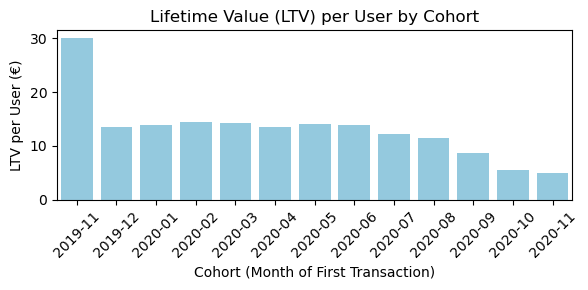

In [41]:
# Q4: Plotting

plt.figure(figsize=(6, 3))
sns.barplot(
    data=ltv_by_cohort,
    x="cohort",
    y="LTV",
    color="skyblue"
)
plt.title("Lifetime Value (LTV) per User by Cohort")
plt.xlabel("Cohort (Month of First Transaction)")
plt.ylabel("LTV per User (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# Q5: Separar el fee por tipo (solo aceptados)
revenue_by_user_type = accepted_fees.groupby(["cohort", "user_id", "type"])["total_amount"].sum().reset_index()

# Promedio por tipo y cohort
avg_revenue_by_type = revenue_by_user_type.groupby(["cohort", "type"])["total_amount"].mean().reset_index()
avg_revenue_by_type.columns = ["cohort", "fee_type", "avg_revenue_per_user"]
avg_revenue_by_type

,cohort,fee_type,avg_revenue_per_user
0,2019-11,instant_payment,20.000000
1,2019-11,postpone,10.000000
2,2019-12,incident,7.592593
3,2019-12,instant_payment,8.928571
4,2019-12,postpone,8.333333
5,2020-01,incident,6.666667
6,2020-01,instant_payment,8.387097
7,2020-01,postpone,9.411765
8,2020-02,incident,7.500000
9,2020-02,instant_payment,9.864865


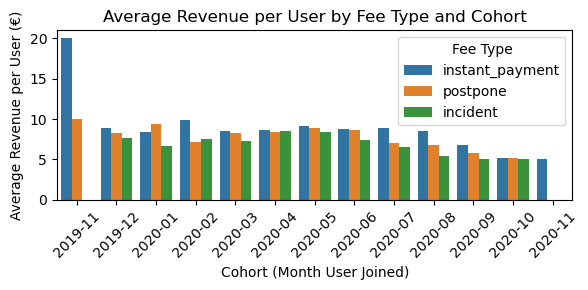

In [43]:
#Q5: Plotting

plt.figure(figsize=(6, 3))
sns.barplot(
    data=avg_revenue_by_type,
    x="cohort",
    y="avg_revenue_per_user",
    hue="fee_type"
)
plt.title("Average Revenue per User by Fee Type and Cohort")
plt.xlabel("Cohort (Month User Joined)")
plt.ylabel("Average Revenue per User (€)")
plt.xticks(rotation=45)
plt.legend(title="Fee Type")
plt.tight_layout()
plt.show()

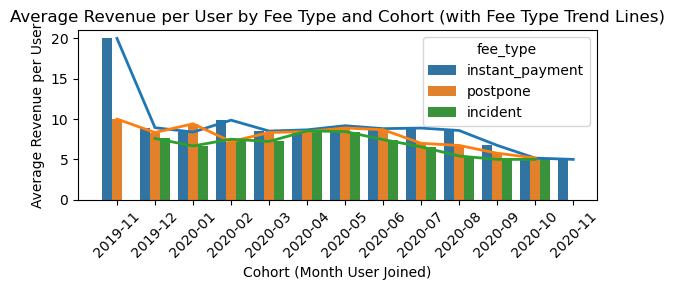

In [44]:
plt.figure(figsize=(6, 3))

# Barras por tipo de fee
sns.barplot(
    data=avg_revenue_by_type,
    x="cohort",
    y="avg_revenue_per_user",
    hue="fee_type"
)

# Línea por tipo de fee (superpuesta)
sns.lineplot(
    data=avg_revenue_by_type,
    x="cohort",
    y="avg_revenue_per_user",
    hue="fee_type",
    markers=True,
    linewidth=2,
    legend=False  # opcional si ya está la leyenda arriba
)

plt.title("Average Revenue per User by Fee Type and Cohort (with Fee Type Trend Lines)")
plt.xlabel("Cohort (Month User Joined)")
plt.ylabel("Average Revenue per User")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Interpretation of Results:

✅ 2019-11 cohort has the highest average revenue per user, by far — almost $20 per user.
+ Users generated almost €20 in instant_payment fees alone, more than any other fee type.

which may indicate:
+ Very engaged early adopters
+ A small but high-value user base
+ Or longer time to accumulate revenue

📉 From 2019-12 to mid-2020, average revenue per user remains fairly stable (+-€10) — these cohorts might have more consistent behavior.
+ postpone remains dominant, but not as extreme as in 2019-11.

⬇️ Starting around 2020-08, there’s a clear downward trend (all fee types):
Cohorts like 2020-09, 2020-10, and 2020-11 show much lower user value, around €5 per user, this could indicate:
+ Decreased user engagement
+ Shorter lifetime (users haven't been active long enough)
+ Lower conversion or retention quality
+ Or you’re acquiring lower-value users as you scale"

🧩 The incident fee type:
+ Has a relatively consistent presence since 2020-01.